In [35]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [36]:
from datetime import timedelta
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import spatial
import math
import os
from matplotlib.pyplot import figure
from datetime import datetime
import warnings
import ipywidgets as widgets
from dateutil.relativedelta import relativedelta

warnings.filterwarnings('ignore')

pd.options.mode.chained_assignment = None


#user = "002"
#train_month = "200811"
#test_month = "200812"
confidence_thrshld = 0.4 #minimum confidence for path predictions
month = "200811" #model to be used for path predictions
state_d_thrhld = 200
src_path = "C:/Users/12sha/Documents/thesislocation/code_/stay points/v0.6 results"

In [37]:
#reusing old folder to fetch users and their corresponding month year with highest data

usern_mnth_df = pd.DataFrame()
usern_mnth_df['user'] = ""
usern_mnth_df['year'] = ""
usern_mnth_df['month'] = ""

file_list = glob.glob("C:/Users/12sha/Documents/thesislocation/Data/User stay points(month-maxdata, 50m 30min)/*.png")
for i in range(0, len(file_list)):
    file_name = file_list[i]
    user = file_name[88:91]
    year = file_name[102:106]
    month = file_name[106:108]
    month = int(month)
    usern_mnth_df.loc[i, 'user'] = user
    usern_mnth_df.loc[i, 'year'] = year
    usern_mnth_df.loc[i, 'month'] = "{0:0=2d}".format(month)
usern_mnth_df = usern_mnth_df.drop_duplicates()
usern_mnth_df = usern_mnth_df.reset_index(drop=True)

#usern_mnth_df.to_csv("C:/Users/12sha/Documents/thesislocation/Data/user_highestdata.csv", sep='\t', encoding='utf-8')

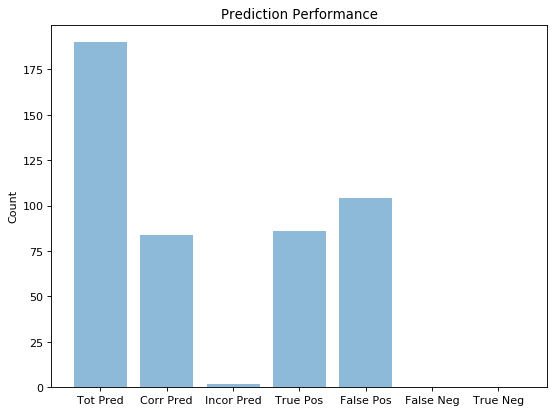

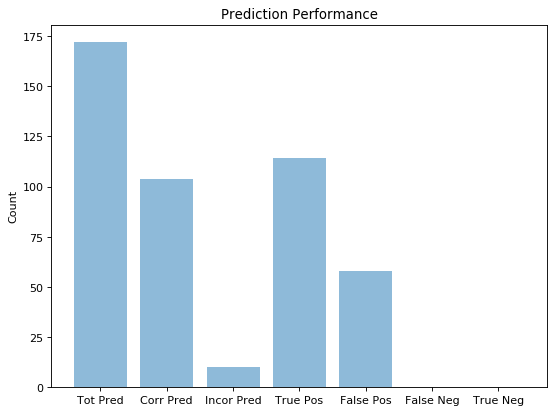

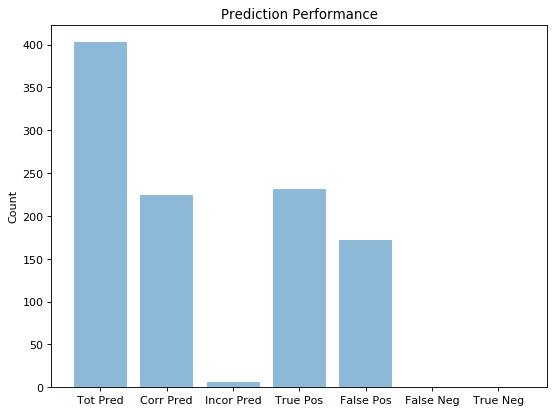

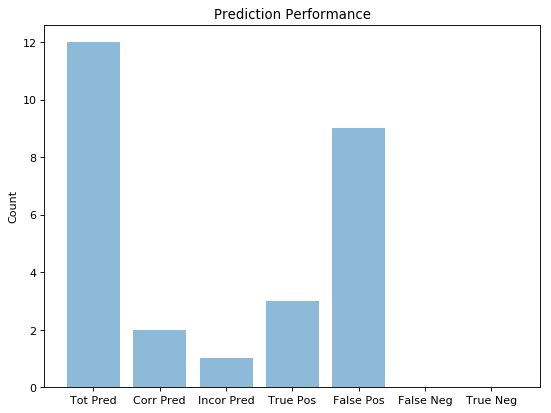

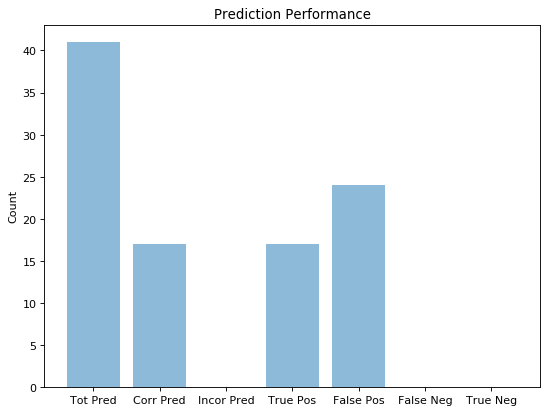

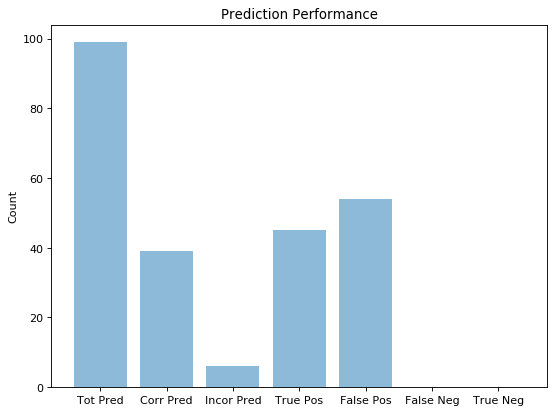

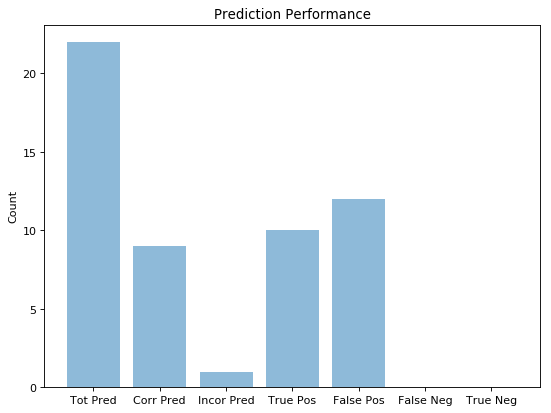

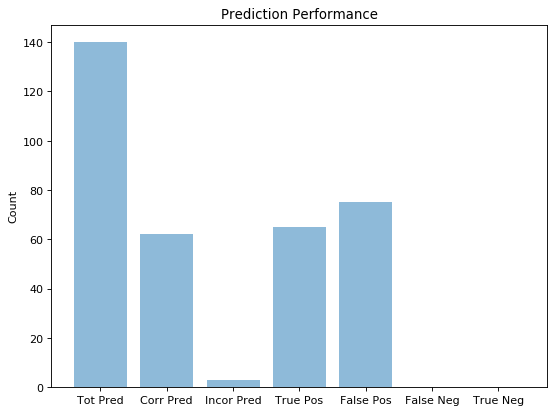

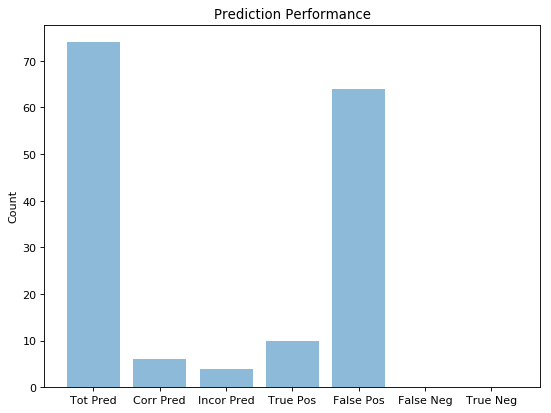

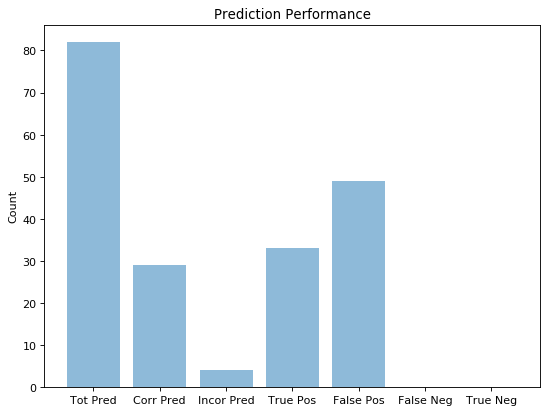

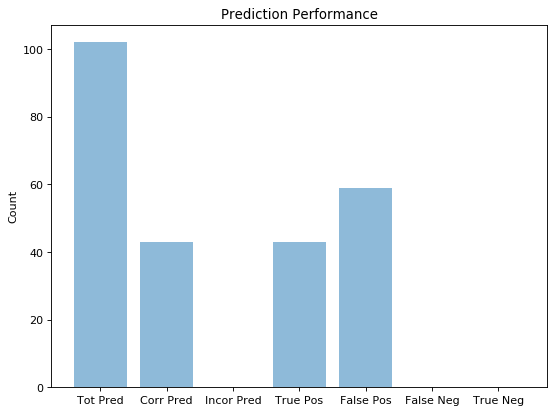

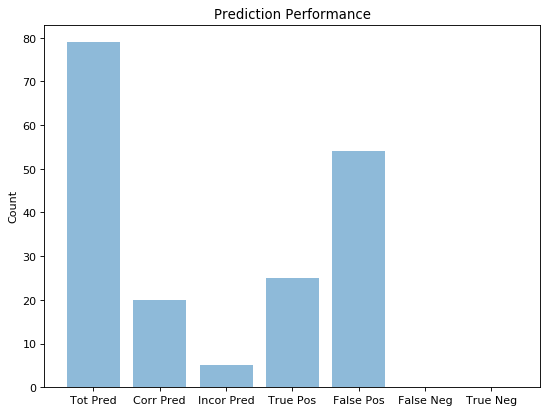

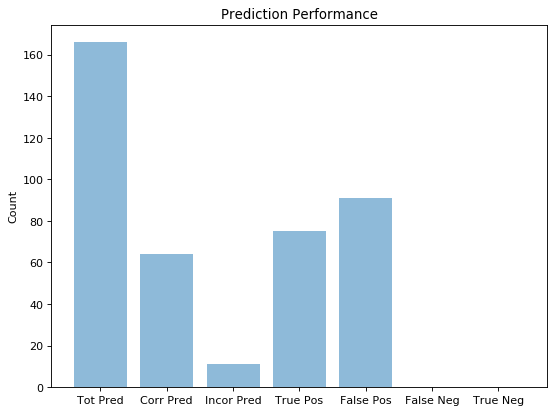

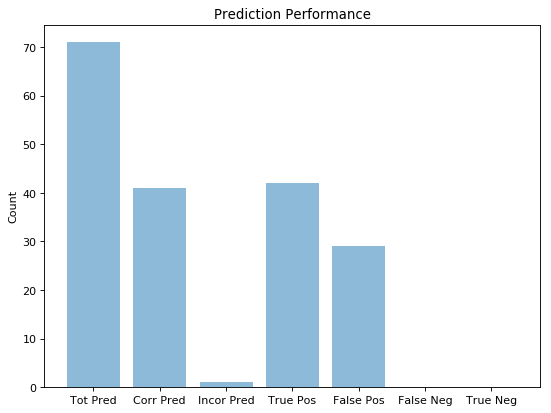

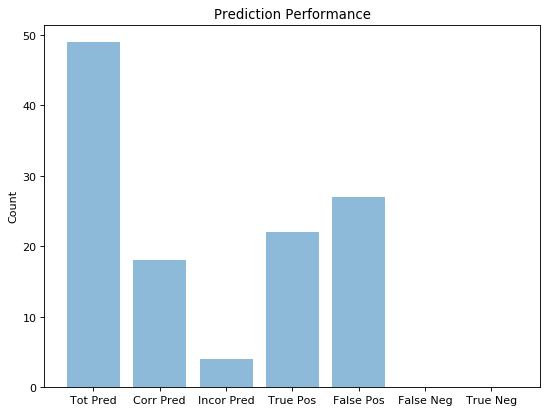

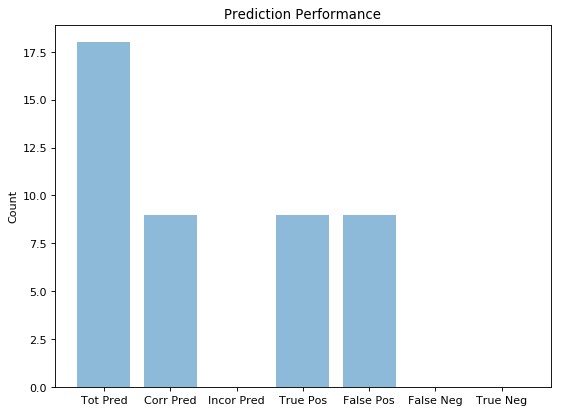

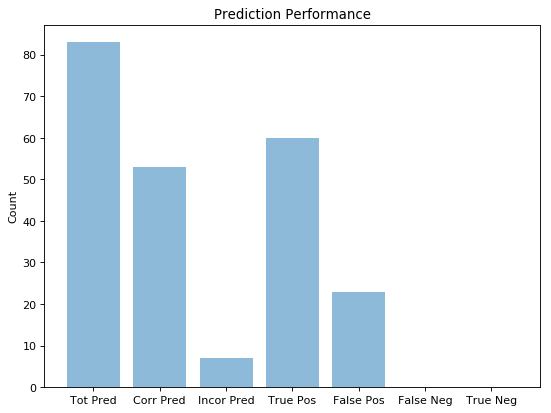

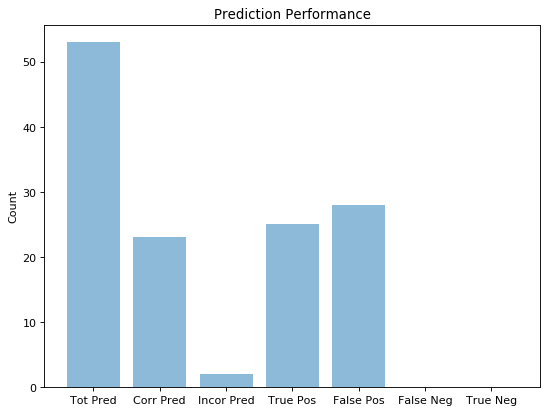

In [36]:

#True positives, true negatives, false positives, false negatives, accuracy

# Find distance between two lan:lon points in meters
def meters(lat1, lon1, lat2, lon2):
    R = 6378.137  # Radius of earth in KM
    dlat = lat2 * math.pi / 180 - lat1 * math.pi / 180
    dlon = lon2 * math.pi / 180 - lon1 * math.pi / 180
    a = math.sin(dlat / 2) * math.sin(dlat / 2) + math.cos(lat1 * math.pi / 180) * math.cos(
        lat2 * math.pi / 180) * math.sin(dlon / 2) * math.sin(dlon / 2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    d = R * c
    return d * 1000  # meters


# calculate prediction parameters
def check_pred(indx_row):
    global predic_df
    global tobepredicted_df
    global correct_pred
    global incorrect_pred
    global true_pos
    global false_pos
    global true_neg
    global false_neg

    true_pred = False
    visit_next_hour = False
    visit_count_next_hour = 0
    curr_hour = tobepredicted_df.loc[indx_row, 'Hour']
    curr_date = tobepredicted_df.loc[indx_row, 'Date']

    # check if there are points found in next hour
    for k in range(indx_row + 1, len(tobepredicted_df)):

        next_hour = tobepredicted_df.loc[k, 'Hour']
        next_date = tobepredicted_df.loc[k, 'Date']

        if (curr_hour != next_hour) or (curr_date != next_date):

            if (curr_hour == 23) and (next_date == curr_date + timedelta(days=1)) and (next_hour == 0):
                visit_next_hour = True
                visit_count_next_hour = visit_count_next_hour + 1
            elif (next_date == curr_date) and (next_hour == curr_hour + 1):
                visit_next_hour = True
                visit_count_next_hour = visit_count_next_hour + 1
            else:
                break

    # visit encountered in next hour: Either:
    #      A. True Positive, or
    #      B. False Negative
    if visit_next_hour == True:

        # B. False Negative
        if predic_df.empty:
            false_neg = false_neg + 1
        # A. True Positive
        else:
            true_pos = true_pos + 1

            # check if prediction is correct or incorrect
            for l in range(1, visit_count_next_hour + 1):

                true_lat = tobepredicted_df['StateMeanLat'][indx_row + l]
                true_lon = tobepredicted_df['StateMeanLon'][indx_row + l]
                true_pred = False
                for i in range(0, len(predic_df)):

                    pred_lat = predic_df.loc[i, 'Latitude']
                    pred_lon = predic_df.loc[i, 'Longitude']

                    if meters(true_lat, true_lon, pred_lat, pred_lon) <= state_d_thrhld:
                        correct_pred = correct_pred + 1
                        true_pred = True
                        break

                if true_pred == True:
                    break

            if true_pred == False:
                incorrect_pred = incorrect_pred + 1

    # visit not encountered in next hour: Either:
    #      A. False Positive, or
    #      B. True Negative
    else:
        # B. True Negative
        if predic_df.empty:
            true_neg = true_neg + 1
        # A. False Positive
        else:
            false_pos = false_pos + 1


def predict():
    global trained_model_df
    global staypts_df
    global tobepredicted_df
    global predic_df
    global total_pred
    global correct_pred
    global incorrect_pred
    global true_pos
    global false_pos
    global true_neg
    global false_neg

    pred_made = False
    tobepredicted_df = staypts_df[['StateId', 'StateMeanLat', 'StateMeanLon', 'Timestamp']]
    tobepredicted_df.Timestamp = pd.to_datetime(tobepredicted_df.Timestamp)
    tobepredicted_df['Date'] = tobepredicted_df['Timestamp'].dt.date
    tobepredicted_df['Hour'] = tobepredicted_df['Timestamp'].dt.hour
    tobepredicted_df = tobepredicted_df.drop(['Timestamp'], axis=1)
    tobepredicted_df = tobepredicted_df.drop_duplicates()
    tobepredicted_df = tobepredicted_df.reset_index(drop=True)

    file_name = "Predictions.csv"
    file = dest_predicted_dir + file_name

    # remove if the file already exists
    try:
        os.remove(file)
    except OSError:
        pass

    for j in range(0, len(tobepredicted_df)):

        new_lat = tobepredicted_df['StateMeanLat'][j]
        new_lon = tobepredicted_df['StateMeanLon'][j]
        hour = tobepredicted_df.loc[j, 'Hour']

        for i in range(0, len(trained_model_df)):

            trn_lat = trained_model_df['AvgLat'][i]
            trn_lon = trained_model_df['AvgLon'][i]
            predic_df = pd.DataFrame()
            pred_made = False

            if meters(trn_lat, trn_lon, new_lat, new_lon) <= state_d_thrhld:
                # prediction is made
                pred_made = True
                total_pred = total_pred + 1

                cluster_id = trained_model_df['StateId'][i]
                
                jmp_dat = False
                if hour == 23:
                    jmp_dat = True

                if jmp_dat == True:
                    from_col_no = 5
                    to_col_no = from_col_no + trained_model_df['StateId'].nunique()
                    predic_df = trained_model_df.iloc[i + 1:i + 2, from_col_no:to_col_no]
                else:
                    from_col_no = trained_model_df['StateId'].nunique() * (hour+1) + 5
                    to_col_no = from_col_no + trained_model_df['StateId'].nunique()
                    predic_df = trained_model_df.iloc[i:i + 1, from_col_no:to_col_no]

                predic_df = predic_df.T
                predic_df['StateId'] = cluster_id
                predic_df['PredState'] = predic_df.index
                predic_df['PredState'] = predic_df['PredState'].map(lambda x: x.split('-', 2)[-1])
                predic_df.columns = ['Probability', 'StateId', 'PredState']

                # predic_df = predic_df.sort_values('Probability', ascending=False).head(10)
                predic_df = predic_df.sort_values('Probability', ascending=False)
                predic_df['DateHour'] = str(tobepredicted_df['Date'][j]) + " " + str(tobepredicted_df['Hour'][j])
                predic_df['Address'] = 0
                predic_df['Latitude'] = 0.0
                predic_df['Longitude'] = 0.0
                predic_df = predic_df.reset_index(drop=True)

                for k in range(0, len(predic_df)):
                    # import pdb; pdb.set_trace()
                    clus_to_find = int(float(predic_df['PredState'][k]))
                    add = trained_model_df.loc[(trained_model_df['StateId'] == clus_to_find), 'Address'].values[0]
                    lat = trained_model_df.loc[(trained_model_df['StateId'] == clus_to_find), 'AvgLat'].values[0]
                    lon = trained_model_df.loc[(trained_model_df['StateId'] == clus_to_find), 'AvgLon'].values[0]

                    predic_df.loc[k, 'Address'] = add
                    predic_df.loc[k, 'Latitude'] = lat
                    predic_df.loc[k, 'Longitude'] = lon

                #                 print("Prediction --\n")
                #                 print("Current hour - " + str(hour))
                #                 print("\nPrediction\n")
                #                 print(predic_df)

                predic_df.to_csv(file, mode='a')
                break

        # if prediction was made, calculate prediction parameters
        if pred_made == True:
            check_pred(j)

    # plot parameters
    figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
    objects = ('Tot Pred', 'Corr Pred', 'Incor Pred', 'True Pos', 'False Pos', 'False Neg', 'True Neg')
    y_pos = np.arange(len(objects))
    performance = [total_pred, correct_pred, incorrect_pred, true_pos, false_pos, false_neg, true_neg]

    plt.bar(y_pos, performance, align='center', alpha=0.5)
    plt.xticks(y_pos, objects)
    plt.ylabel('Count')
    plt.title('Prediction Performance')
    destpng = dest_predicted_dir + "pred performance.png"
    plt.savefig(destpng)
    plt.show()

    # prediction parameters
    if total_pred != 0:
        acc = correct_pred / total_pred * 100
    else:
        acc = 0

    if true_pos + false_pos != 0:
        true_pos_rate = true_pos / (true_pos + false_neg) * 100
    else:
        true_pos_rate = 0

    if total_pred != 0:
        acc_pos = (true_pos + true_neg) / total_pred * 100
    else:
        acc_pos = 0

    if true_pos + false_pos != 0:
        pos_pred_value = true_pos / (true_pos + false_pos) * 100
        false_dis_rate = false_pos / (true_pos + false_pos) * 100
    else:
        pos_pred_value = 0
        false_dis_rate = 0

    prediction_perf = ("Total Predictions: " + str(total_pred) + "\nCorrect Predictions: " + str(correct_pred) +
                       "\nIncorrect Predictions: " + str(incorrect_pred) +
                       "\nAccuracy%: " + str(acc) +
                       "\nTrue Positives: " + str(true_pos) + "\nFalse Positives: " + str(false_pos) +
                       "\nFalse Negatives: " + str(false_neg) + "\nTrue Negatives: " + str(true_neg) +
                       "\nTrue positive rate(Recall)%: " + str(true_pos_rate) +
                       # "\nFalse positive rate(Fall-out): " + str(false_pos_rate) +
                       "\nAccuracy Positives%: " + str(acc_pos) +
                       "\nPositive predictive value(Precision)%: " + str(pos_pred_value) +
                       "\nFalse discovery rate%: " + str(false_dis_rate))
    text_file = dest_predicted_dir + "corr pred ratio " + str(acc) + " .txt"
    f = open(text_file, "w+")
    f.write(prediction_perf)


# -----------------------------------------------------------------------------------------
# train_month = "200705"
# test_month = "200704"
# user = "021"
# state_d_thrhld = 200
# src_path = "C:/Users/12sha/Documents/thesislocation/code_/stay points/v0.6 results"
for i in range (2, 20):
    user = usern_mnth_df.loc[i, 'user']
    month = usern_mnth_df.loc[i, 'year'] + usern_mnth_df.loc[i, 'month'] + "01"
    
    date_s = usern_mnth_df.loc[i, 'year'] + usern_mnth_df.loc[i, 'month'] + "01"
    date_d = datetime(year=int(month[0:4]), month=int(month[4:6]), day=int(date_s[6:8]))
    next_mn = date_d + relativedelta(months=1)
    next_mn = next_mn.strftime('%Y%m%d')
    
    train_month = month[:-2]
    test_month = next_mn[:-2]
    
    tobepredicted_df = pd.DataFrame()
    predic_df = pd.DataFrame()

    # staypoints file path
    stay_points_file = src_path + "/User " + user + "/" + test_month + "/staypoints/staypoints.csv"
    # trained model
    trained_model_file = src_path + "/User " + user + "/" + train_month + "/markovchains/final.csv"
    # predicted file
    dest_predicted_dir = src_path + "/User " + user + "/" + test_month + "/predict/"

    # counts
    total_pred = 0
    correct_pred = 0
    incorrect_pred = 0
    true_pos = 0
    false_pos = 0
    true_neg = 0
    false_neg = 0

    trained_model_df = pd.read_csv(trained_model_file, header=0)
    staypts_df = pd.read_csv(stay_points_file, header=0, sep='\t')

    predict()


In [38]:

#Cosine Similarity

# Find distance between two lan:lon points in meters
def meters(lat1, lon1, lat2, lon2):
    R = 6378.137  # Radius of earth in KM
    dLat = lat2 * math.pi / 180 - lat1 * math.pi / 180
    dLon = lon2 * math.pi / 180 - lon1 * math.pi / 180
    a = math.sin(dLat / 2) * math.sin(dLat / 2) + math.cos(lat1 * math.pi / 180) * math.cos(
        lat2 * math.pi / 180) * math.sin(dLon / 2) * math.sin(dLon / 2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    d = R * c
    return d * 1000  # meters

def dotproduct(v1, v2):
    return sum((a*b) for a, b in zip(v1, v2))

def length(v):
    return math.sqrt(dotproduct(v, v))

def find_similarity(pred_prob, act_prob_all):
    return math.acos(dotproduct(pred_prob, act_prob_all) / (length(pred_prob) * length(act_prob_all)))

# def find_similarity(pred_prob, act_prob_all):
#     result = 1 - spatial.distance.cosine(pred_prob, act_prob_all)
#     return result

# calculate prediction parameters
def check_pred(hour, indx_row):
    global predic_df
    global hrywghts_df
    global similarity_arr

    pred_prob = predic_df['PredProbability'].values
    act_prob_all = [0] * len(pred_prob)
    curr_date = hrywghts_df.loc[indx_row, 'Date']
    state_wght = hrywghts_df.loc[indx_row, str(hour)]

    jmp_dat = False
    if hour == 23:
        jmp_dat = True

    # check if there are points found in next hour
    hrywghts_day_df = hrywghts_df.loc[hrywghts_df['Date'] == curr_date]
    hrywghts_day_df = hrywghts_day_df.reset_index(drop=True)
    for k in range(0, len(hrywghts_day_df)):
        if jmp_dat == True:
            if k + 1 < len(hrywghts_day_df):
                next_hour = 0
                row = k + 1
            else:
                break
        else:
            next_hour = hour + 1
            row = k

        if hrywghts_day_df.loc[row, str(next_hour)] != 0:

            true_lat = hrywghts_day_df['AvgLat'][row]
            true_lon = hrywghts_day_df['AvgLon'][row]

            for i in range(0, len(predic_df)):
                pred_lat = predic_df.loc[i, 'Latitude']
                pred_lon = predic_df.loc[i, 'Longitude']

                if meters(true_lat, true_lon, pred_lat, pred_lon) <= state_d_thrhld:
                    act_prob_all[i] = hrywghts_day_df.loc[k, str(next_hour)]
                    break

    #if the actual_prob_all has all 0's, this means the prediction is incorrect and hence similarity is 0.
    if np.mean(act_prob_all) == 0:
        similarity = 90
    else:
        similarity = find_similarity(pred_prob, act_prob_all)

    similarity_arr = np.append(similarity_arr, similarity)
    predic_df['ActProbability'] = act_prob_all
    predic_df['Similarity'] = similarity


def predict():
    global trained_model_df
    global hrywghts_df
    global predic_df

    file_name = "Similarity.csv"
    file = dest_predicted_dir + file_name

    # remove if the file already exists
    try:
        os.remove(file)
    except OSError:
        pass

    for j in range(0, len(hrywghts_df)):
        # If user has data for hours
        for h in range(0, 24):
            if hrywghts_df.loc[j, str(h)] != 0:
                hour = h
                new_lat = hrywghts_df['AvgLat'][j]
                new_lon = hrywghts_df['AvgLon'][j]
                # current state probabilities
                curr_state_prob = hrywghts_df.loc[j, str(h)]

                for i in range(0, len(trained_model_df)):

                    trn_lat = trained_model_df['AvgLat'][i]
                    trn_lon = trained_model_df['AvgLon'][i]
                    predic_df = pd.DataFrame()

                    if meters(trn_lat, trn_lon, new_lat, new_lon) <= state_d_thrhld:

                        cluster_id = trained_model_df['StateId'][i]

                        # next hour prediction probabilities
                        jmp_dat = False
                        if hour == 23:
                            jmp_dat = True

                        if jmp_dat == True:
                            from_col_no = 5
                            to_col_no = from_col_no + trained_model_df['StateId'].nunique()
                            predic_df = trained_model_df.iloc[i + 1:i + 2, from_col_no:to_col_no]
                        else:
                            from_col_no = trained_model_df['StateId'].nunique() * (hour + 1) + 5
                            to_col_no = from_col_no + trained_model_df['StateId'].nunique()
                            predic_df = trained_model_df.iloc[i:i + 1, from_col_no:to_col_no]

                        predic_df = (predic_df * curr_state_prob).T

                        predic_df['StateId'] = cluster_id
                        predic_df['PredState'] = predic_df.index
                        predic_df['PredState'] = predic_df['PredState'].map(lambda x: x.split('-', 2)[-1])

                        predic_df.columns = ['PredProbability', 'StateId', 'PredState']

                        # predic_df = predic_df.sort_values('Probability', ascending=False).head(10)
                        predic_df = predic_df.sort_values('PredProbability', ascending=False)
                        predic_df['DateHour'] = str(hrywghts_df['Date'][j]) + " " + str(hour)
                        predic_df['Address'] = 0
                        predic_df['Latitude'] = 0.0
                        predic_df['Longitude'] = 0.0
                        predic_df = predic_df.reset_index(drop=True)

                        for k in range(0, len(predic_df)):
                            # import pdb; pdb.set_trace()
                            clus_to_find = int(float(predic_df['PredState'][k]))
                            add = trained_model_df.loc[(trained_model_df['StateId'] == clus_to_find), 'Address'].values[
                                0]
                            lat = trained_model_df.loc[(trained_model_df['StateId'] == clus_to_find), 'AvgLat'].values[
                                0]
                            lon = trained_model_df.loc[(trained_model_df['StateId'] == clus_to_find), 'AvgLon'].values[
                                0]

                            predic_df.loc[k, 'Address'] = add
                            predic_df.loc[k, 'Latitude'] = lat
                            predic_df.loc[k, 'Longitude'] = lon

                        # if prediction was made, calculate prediction parameters
                        check_pred(hour, j)

                        predic_df.to_csv(file, mode='a')
                        break


# -------------------------------------------------------------------------------------------------------
# train_month = "201109"
# test_month = "201110"
# user = "020"
# state_d_thrhld = 200
# src_path = "C:/Users/12sha/Documents/thesislocation/code_/stay points/v0.6 results"

for i in range (2, 20):
    user = usern_mnth_df.loc[i, 'user']
    month = usern_mnth_df.loc[i, 'year'] + usern_mnth_df.loc[i, 'month'] + "01"
    
    date_s = usern_mnth_df.loc[i, 'year'] + usern_mnth_df.loc[i, 'month'] + "01"
    date_d = datetime(year=int(month[0:4]), month=int(month[4:6]), day=int(date_s[6:8]))
    next_mn = date_d + relativedelta(months=1)
    next_mn = next_mn.strftime('%Y%m%d')
    
    train_month = month[:-2]
    test_month = next_mn[:-2]
    
    tobepredicted_df = pd.DataFrame()
    predic_df = pd.DataFrame()

    # hourly weights file
    hrly_wghts_file = src_path + "/User " + user + "/" + test_month + "/hourlyweights/hourlyweights.csv"
    # trained model
    trained_model_file = src_path + "/User " + user + "/" + train_month + "/markovchains/final.csv"
    # predicted file
    dest_predicted_dir = src_path + "/User " + user + "/" + test_month + "/predict/"

    similarity_arr = []

    trained_model_df = pd.read_csv(trained_model_file, header=0)
    hrywghts_df = pd.read_csv(hrly_wghts_file, header=0, sep='\t')

    predict()

    # save similarity results
    similarity_arr = similarity_arr[np.logical_not(np.isnan(similarity_arr))]
    sim_mean = np.mean(similarity_arr)
    text_file = dest_predicted_dir + "similarity mean " + str(sim_mean) + " .txt"
    f = open(text_file, "w+")
    print("Cosine Similarity is: " + str(sim_mean) + "degrees")


Cosine Similarity is: 7.421752025794811degrees
Cosine Similarity is: 12.872863984707411degrees
Cosine Similarity is: 5.839177209312614degrees
Cosine Similarity is: 9.982781610192477degrees
Cosine Similarity is: 11.56399672641026degrees
Cosine Similarity is: 10.57840605543771degrees
Cosine Similarity is: 7.876817355495082degrees
Cosine Similarity is: 3.953058094465716degrees
Cosine Similarity is: 12.740816503927293degrees
Cosine Similarity is: 10.2775991672384degrees
Cosine Similarity is: 5.5743038082418295degrees
Cosine Similarity is: 11.05186603407593degrees
Cosine Similarity is: 14.710661676777187degrees
Cosine Similarity is: 10.8300270049102degrees
Cosine Similarity is: 7.91153996689157degrees
Cosine Similarity is: 11.365683040509616degrees
Cosine Similarity is: 11.415899797344908degrees
Cosine Similarity is: 20.672560970794688degrees
